## Face image generation using FC layers

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Reshape, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation, Conv2DTranspose

### Defining hyper-parameters

In [21]:
No_images= 400
img_width, img_height= 64, 64
batch_size = 4
No_epochs= 20
codings_size= 10000

### Defining directory of data

In [22]:
# Set the directory where the data is stored
data_dir = "Data/Resized Images/"

# Define the labels
images_name= os.listdir(data_dir)[:No_images]

image_path_list= []
for img_name in images_name: 
    path = os.path.join(data_dir, img_name)
    image_path_list.append(path)
    
image_path_list= np.array(image_path_list)

### Inporting images

In [23]:
# Function to load and preprocess images
def load_images(X, img_width, img_height):
    images = []
    for image_path in X:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values
        images.append(image)

    return np.array(images)

# Load and preprocess images
images= load_images(image_path_list, img_width, img_height)

### Showing som sample face images

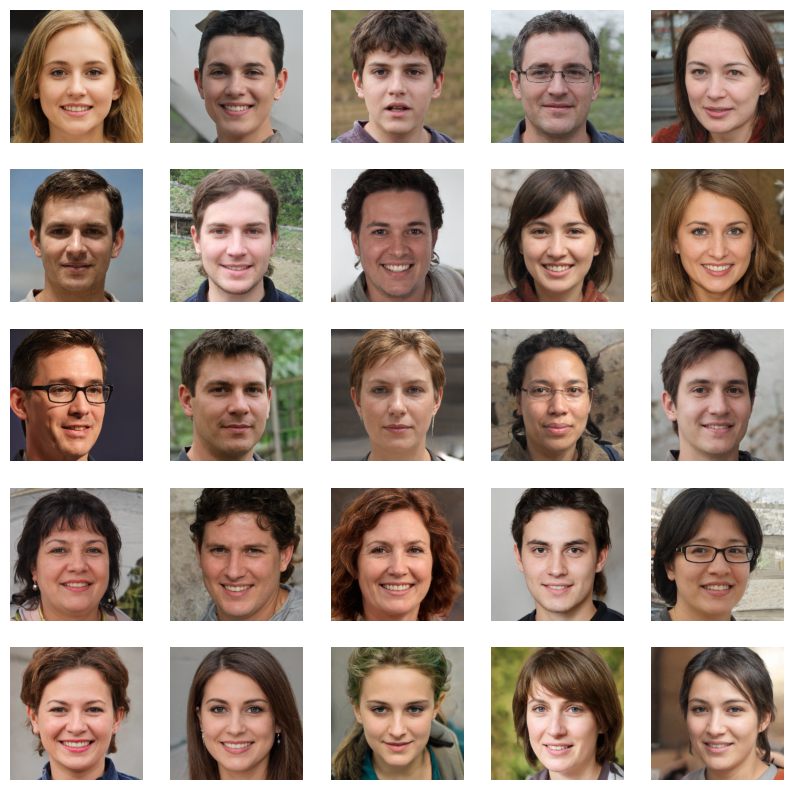

In [24]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = Image.open(np.random.choice(image_path_list))
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Defining the generator model

In [26]:
generator = Sequential([
    Input(shape= codings_size),
    Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.002)),
    Dense(10, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.002)),
    Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.002)),
    Dense(img_width * img_height * 3, activation="sigmoid"),
    Reshape([img_width, img_height, 3])
])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               1000100   
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
 dense_9 (Dense)             (None, 100)               1100      
                                                                 
 dense_10 (Dense)            (None, 12288)             1241088   
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
Total params: 2243298 (8.56 MB)
Trainable params: 2243298 (8.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Defining the discriminator model

In [27]:
discriminator = Sequential([
    Input(shape= (img_width, img_height, 3)),
    Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.002)),
    Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.002)),
    Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_11 (Dense)            (None, 150)               1843350   
                                                                 
 dense_12 (Dense)            (None, 100)               15100     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1858551 (7.09 MB)
Trainable params: 1858551 (7.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Defining the GAN model

In [28]:
gan = Sequential([Input(shape= codings_size), generator, discriminator])
gan.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64, 64, 3)         2243298   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 1858551   
                                                                 
Total params: 4101849 (15.65 MB)
Trainable params: 4101849 (15.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# binary crossentropy is used because the discriminator is a binary classifier
discriminator.compile(loss="binary_crossentropy", optimizer="adam", )

In [30]:
discriminator.trainable = False

In [31]:
# binary_crossentropy is used because the generator is trained based on the discriminator output
gan.compile(loss="binary_crossentropy", optimizer="adam")

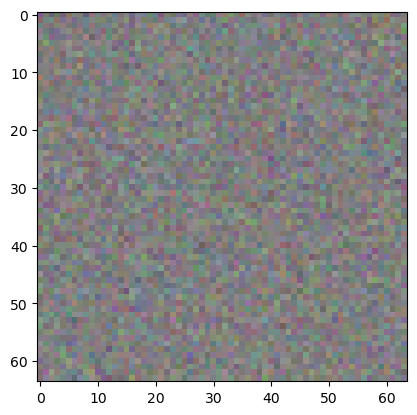

In [32]:
noise = np.random.normal(-1,1,(1,codings_size))
img = generator(noise)
plt.imshow(img[0])
plt.show()

### Training two models 

In [33]:
Dis_loss, Gen_loss= [], []    
for epoch in range(No_epochs):
    loss_D, loss_G = [], []
    for _ in range(images.shape[0] // batch_size):
                
        # phase 1 - training the discriminator
        noise = tf.random.normal(shape=[batch_size, codings_size])
        generated_images = generator(noise)
        
        real_images = images[np.random.randint(0, images.shape[0], batch_size)]
        
        X_fake_and_real = tf.concat([generated_images, real_images], axis=0)
        
        y1 = tf.constant([[0.]] * batch_size + [[0.9]] * batch_size)
        
        discriminator_loss= discriminator.train_on_batch(X_fake_and_real, y1)
        
        # phase 2 - training the generator
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        y2 = tf.constant([[1.]] * batch_size) 
        
        generator_loss= gan.train_on_batch(noise, y2)
        
        loss_G.append(generator_loss)
        loss_D.append(discriminator_loss)
        
    Gen_loss.append(np.mean(loss_G))
    Dis_loss.append(np.mean(loss_D))
    
    print(f'Epoch {epoch + 1}/{No_epochs}, Generator loss: {np.mean(loss_G)}, Discriminator loss: {np.mean(Dis_loss)}')

Epoch 1/20, Generator loss: 10.775720628499984, Discriminator loss: 1.8831457912921905
Epoch 2/20, Generator loss: 19.21559121131897, Discriminator loss: 1.390244958102703
Epoch 3/20, Generator loss: 10.104227867126465, Discriminator loss: 1.14448823928833
Epoch 4/20, Generator loss: 8.07421811580658, Discriminator loss: 1.0009226962924003
Epoch 5/20, Generator loss: 8.531281943321227, Discriminator loss: 0.9026990781426429
Epoch 6/20, Generator loss: 8.854778337478638, Discriminator loss: 0.8273166901866594
Epoch 7/20, Generator loss: 9.155079460144043, Discriminator loss: 0.7671864922557557
Epoch 8/20, Generator loss: 9.078015975952148, Discriminator loss: 0.7180080644786357
Epoch 9/20, Generator loss: 9.00754698753357, Discriminator loss: 0.6768365253342522
Epoch 10/20, Generator loss: 9.145440526008606, Discriminator loss: 0.6417694652676582
Epoch 11/20, Generator loss: 8.955537738800048, Discriminator loss: 0.6116060893102125
Epoch 12/20, Generator loss: 6.741656309366226, Discrim

### Ploting the loss values

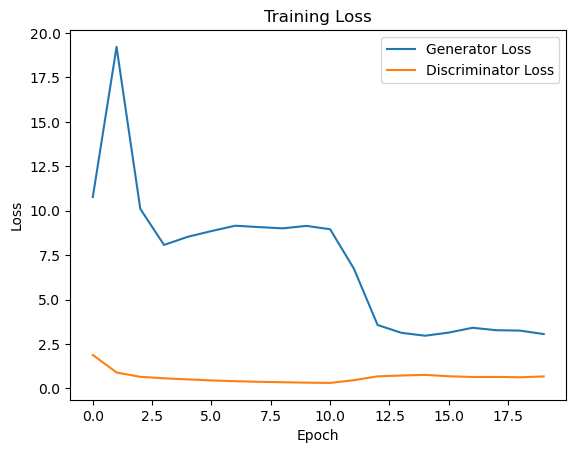

In [34]:
# Plot the loss values
plt.plot(Gen_loss, label='Generator Loss')
plt.plot(Dis_loss, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### A sample generated model

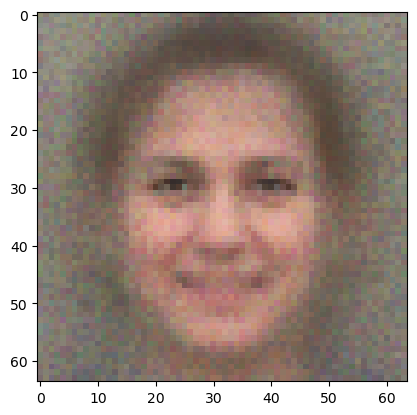

In [35]:
noise = np.random.normal(-1,1,(1,codings_size))
img = generator(noise)
plt.imshow(img[0])
plt.show()